# Predicting churn from telecoms data
Using the Iranian Telecoms data (https://archive.ics.uci.edu/dataset/563/iranian+churn+dataset) which comprises information on 3150 customers, sampled over a 12 month period, I want to create a model that can predict customer churn from the recorded variables. 

Since this is running in VS Code, I have created a new Python environment, churn-pipeline, and then registered it as a Jupyter kernel named Churn Pipeline so I can run notebooks using that environment.

First, verify that the Python interpreter is pointing to the correct environment, and then change the working directory to the project root:

In [1]:
import sys
import os

# Print the path to the Python interpreter currently in use
print(sys.executable)

# Change working directory to the project root
os.chdir("/Users/willbeckman/Documents/Churn_predictor")

# Get current working directory
cwd = os.getcwd()

# Print current working directory to confirm change
print(cwd)

/Users/willbeckman/miniconda3/envs/churn-pipeline/bin/python
/Users/willbeckman/Documents/Churn_predictor


### Load data into database
Here sqlalchemy is used to load the raw customer churn data into a SQLite database. A table called customers_raw is created for use downstream. 

In [2]:
import pandas as pd
import sqlalchemy

# Create a connection to the SQLite database 'churn.db'
engine = sqlalchemy.create_engine("sqlite:///db/churn.db")

# Read in the raw data from the csv file
df = pd.read_csv("data/raw_data/Customer_Churn.csv")

# Write the dataframe to the database (replace if already exists)
df.to_sql("customers_raw", engine, if_exists="replace", index=False)

print("Loaded raw data into customers_raw table. The summary is as follows:")

# Load the table into a DataFrame
df_preview = pd.read_sql("SELECT * FROM customers_raw;", engine)

# Display the DataFrame summary stats
df_preview.describe()

Loaded raw data into customers_raw table. The summary is as follows:


,Customer_ID,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
count,3150.000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,1575.500,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,2.826032,1.077778,1.248254,30.998413,470.972916,0.157143
std,909.471,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.892555,0.267864,0.432069,8.831095,517.015433,0.363993
min,1.000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,0.000000,0.000000
25%,788.250,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,2.000000,1.000000,1.000000,25.000000,113.801250,0.000000
50%,1575.500,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,3.000000,1.000000,1.000000,30.000000,228.480000,0.000000
75%,2362.750,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,3.000000,1.000000,1.000000,30.000000,788.388750,0.000000
max,3150.000,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,5.000000,2.000000,2.000000,55.000000,2165.280000,1.000000


For fun, I am going to remove all customers who have zero seconds of use. I have defined this in db/transformations.sql. The next chunk loads the transformations file and executes the command using sqlite3:

In [3]:
import sqlite3

# Connect to the database and load, then execute the transformations script
with sqlite3.connect("db/churn.db") as conn:
    with open("db/transformations.sql") as f:
        sql_script = f.read()
    conn.executescript(sql_script)

print("Transformations complete. The new summary (for customers_clean) is as follows:")

# Load the table into a DataFrame
df_preview = pd.read_sql("SELECT * FROM customers_clean;", engine)

# Display the DataFrame
df_preview.describe()

Transformations complete. The new summary (for customers_clean) is as follows:


,Customer_ID,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
count,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000
mean,1589.333778,8.020027,0.075100,32.555073,0.990320,4702.352470,73.031041,76.885180,24.718291,2.824433,1.081776,1.220628,30.911215,495.002231,0.138184
std,918.659099,7.234050,0.263597,8.693442,1.544522,4176.980745,56.612210,113.853977,16.786852,0.883847,0.274068,0.414739,8.726265,518.869396,0.345151
min,1.000000,0.000000,0.000000,3.000000,0.000000,8.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,15.000000,2.340000,0.000000
25%,787.750000,2.000000,0.000000,29.000000,0.000000,1644.500000,31.000000,7.000000,12.000000,2.000000,1.000000,1.000000,25.000000,128.157500,0.000000
50%,1602.500000,7.000000,0.000000,35.000000,0.000000,3180.000000,57.000000,23.000000,22.000000,3.000000,1.000000,1.000000,30.000000,242.925000,0.000000
75%,2395.250000,12.000000,0.000000,38.000000,2.000000,6600.750000,98.000000,100.000000,34.000000,3.000000,1.000000,1.000000,30.000000,815.103750,0.000000
max,3150.000000,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,5.000000,2.000000,2.000000,55.000000,2165.280000,1.000000


You can now see that the new min value for Seconds of Use is 8 instead of 0. 

I can now export the "cleaned" data to a csv file for downstream processing. I will place it in data/processed_data/

In [4]:
# Convert the database to a dataframe
df = pd.read_sql("SELECT * FROM customers_clean", engine)

# Save dataframe as a new csv file for downstream processing
df.to_csv("data/processed_data/churn_features.csv", index=False)

print("Exported processed features to data/processed_data/churn_features.csv")

Exported processed features to data/processed_data/churn_features.csv


## Importing clean data and modelling
Before I start to fit any models, I want to make sure that the features are not correlated with one another.

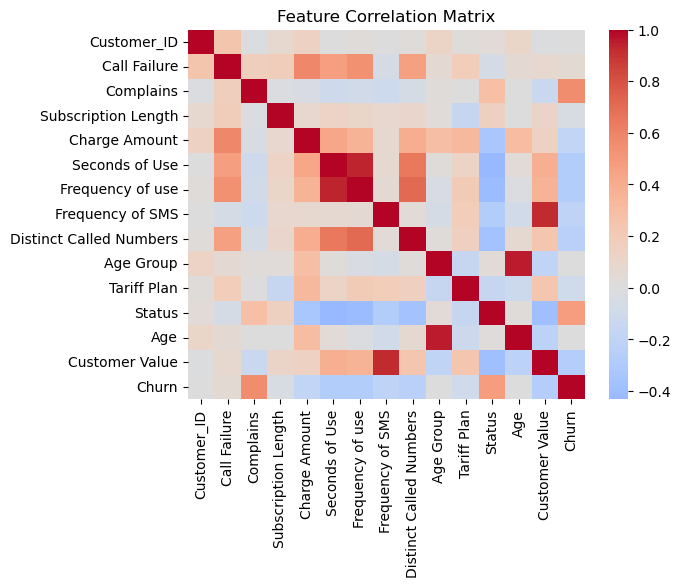

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Read in clean data from processed_data folder
df = pd.read_csv("data/processed_data/churn_features.csv")

# First let's see if any of the features are highly correlated
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()

From the above correlation matrix we can see that several of the features are highly correlated. From this we can also see that Churn is somewhat correlated with Complains, indicating that there may be a relationship between the 2 features. 

Below I have grouped the data into customers that churn and those that do not, and averaged Complains. This suggests that customers who complain are more likely to end their contract. More on this later...

In [6]:
average_complains = df.groupby('Churn')['Complains'].mean()
print(average_complains)

Churn
0    0.015879
1    0.444444
Name: Complains, dtype: float64


Due to their similarities with other features in the correlation matrix above, I will now drop Age Group, Customer Value and Seconds of Use.

Now that we have the best features, and they have been cleaned, we can seperate the churn information from the rest of the variables, and then divide the features and target into a train set and a test set. I will use the XGBoost classifier model to predict churn based on these features, and assess performance. 

The chunk below shows this process, using a grid search of parameters to identify the best model parameters, based on the f1 score (harmonic mean of recall and precision, penalises extreme values more than arithmatic mean). 

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import pickle

# Remove Customer_ID and Churn from the DataFrame and assign it as X
X = df.drop(["Customer_ID","Churn","Age Group","Customer Value","Seconds of Use"], axis=1)

# Assign Churn information as y
y = df["Churn"]

# Split features (X) and target (y) into training and test data. 20% is assigned to the test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the categorical variables and the numerical variables
categorical_cols = ["Tariff Plan", "Status", "Complains"]
numeric_cols = ["Call Failure",
                "Subscription Length","Charge Amount",
                "Frequency of use","Frequency of SMS","Distinct Called Numbers",
                "Age"]

# Create the preprocessing steps to one-hot encode categorical variables 
# and leave numerical variables untouched. You do not need to scale the 
# numerical data for XGBoost
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

# Apply the preprocessing pipeline and fit the XGBoost classifier model
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("xgb", XGBClassifier(eval_metric="logloss"))
])

# Define parameter grid for gridsearch
param_grid = {
    "xgb__n_estimators": [200, 400],
    "xgb__learning_rate": [0.05, 0.1],
    "xgb__max_depth": [4, 6],
    "xgb__subsample": [0.8, 1.0],
    "xgb__colsample_bytree": [0.8, 1.0],
    "xgb__scale_pos_weight": [1, 3, 5]}  

# Run grid search on parameter grid. I've set verbose to 1 to limit output. 
# cv of 3 means the training data is divided into 3 subsets for training, validated on 1 subset. 
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,             
    scoring="f1",     
    verbose=1,
    n_jobs=-1)

# Fit the model with the gridsearch parameters to training data
grid.fit(X_train, y_train)

# Print the best parameters based on f1 score, and print the f1 score
print("Best Parameters:", grid.best_params_)
print("Best Score (F1):", grid.best_score_)

best_model = grid.best_estimator_

# Save the best model as a pickle file
with open("ml/xgb_best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Saved best model to ml/xgb_best_model.pkl")


Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best Parameters: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__n_estimators': 200, 'xgb__scale_pos_weight': 3, 'xgb__subsample': 1.0}
Best Score (F1): 0.8730914736965953
Saved best model to ml/xgb_best_model.pkl


After fitting the models using the parameter grid, the optimal model is found to have an F1 score of 0.87. The model has the following parameters:
- 200 estimators (# of trees/boosting rounds)
- Learning rate (eta) of 0.05
- Max tree depth of 6 branches
- Subsample of 1 means all data is used for each training round
- Sampling of columns is q, meaning all features are used in each tree
- Positive weight scaling of 3, meaning positive cases are assigned more weight

We can visualise the models performance by plotting a confusion matrix: 

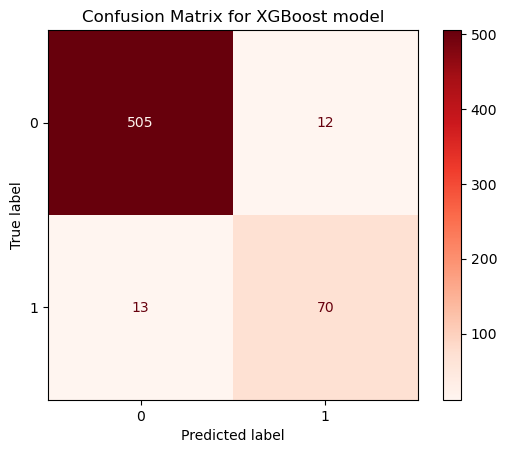

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create a confusion matrix from the best model using the test data
disp = ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test,cmap='Reds')
plt.title("Confusion Matrix for XGBoost model")
plt.show()

From this plot we can see that the model performs well at predicting true negatives (97.7%), with only 12 out of the 517 negative cases wrongly predicted as positive churn (2.3%).

The precision is (70)/(70+12) = 0.85

The recall is (70)/(70+13) = 0.84

Another way to visualise this is by using the ROC Curve and AUC analysis:

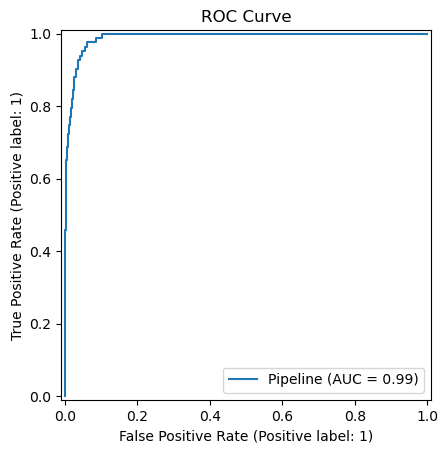

In [9]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve")
plt.show()


An AUC of 0.99 suggests that the model will consistently rank a positive outcome higher than a negative outcome. i.e. 99% of the time, the model will rank a churn case as more likely to churn than a non-churn case. 

We can now run a sensitivity analysis to see which features contribute the most to predictions. I will use SHAP for this (best for tree-based models, like XGBoost):

PermutationExplainer explainer: 2397it [05:05,  7.77it/s]                          
/var/folders/k4/pmdhq_5d7lvb7xqphjjdt63c0000gn/T/ipykernel_54461/2876916848.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_processed, feature_names=feature_names)


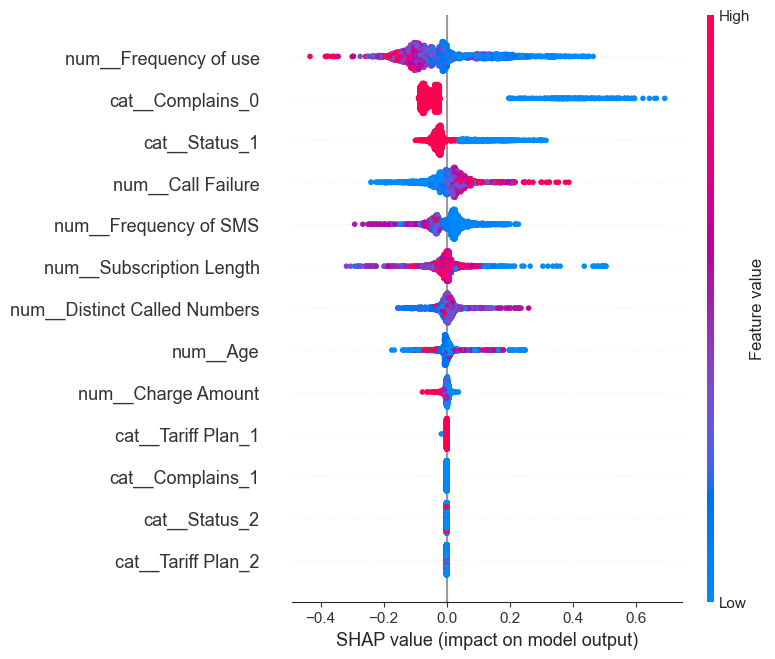

In [79]:
import shap
import numpy as np

# Preprocess the training data
X_train_processed = best_model.named_steps["preprocess"].transform(X_train)
feature_names = best_model.named_steps["preprocess"].get_feature_names_out()

# Make a callable prediction function
# Use predict_proba and take probability of the positive class
model_callable = lambda X: best_model.named_steps["xgb"].predict_proba(X)[:, 1]

# Create a SHAP Explainer with the callable
explainer = shap.Explainer(model_callable, X_train_processed, feature_names=feature_names)

# Compute SHAP values
shap_values = explainer(X_train_processed)

# Global summary plot
shap.summary_plot(shap_values, X_train_processed, feature_names=feature_names)


This SHAP analysis shows how the values of each feature impact the model's predictions. One feature that clearly has a large impact on the model's prediction is the categorical variable Complaints_0, which informs on whether the customer has recorded any complaints (here we are quantifying 0 complaints as 1, and any complaints as 0). This reveals when customers have complained (i.e. Complaints_0 = 0) the model is more likely to predict Churn. 

This model can now be used by the Telecoms company to predict whether customers are likely to end their contracts or not. 

The next step would be to create a dashboard or web app so that users can run this app in their browser.


# Identifying trends in the data (PCA)
Now that I have built a good predictor of churn, the next thing I can do is to dig deeper into the data to identify the reasons why customers might be ending their contracts. To do this, I will perform a simple PCA to map the data in 2D space, and then if necessary, cluster the data:

Explained variance ratio: [0.34720757 0.15596541]
                         PC1_loading  PC2_loading  PC1_corr  PC2_corr
Call Failure               -0.043858     0.038539 -0.260557  0.153454
Subscription Length         0.043858    -0.038539  0.260557 -0.153454
Charge Amount               0.102559    -0.099828  0.402638 -0.262672
Frequency of use           -0.102559     0.099828 -0.402638  0.262672
Frequency of SMS            0.004049    -0.031761  0.025011 -0.131489
Distinct Called Numbers    -0.004049     0.031761 -0.025011  0.131489
Age                         0.486186     0.100232  0.791488  0.109362
Tariff Plan_1               0.128359    -0.119237  0.208963 -0.130098
Tariff Plan_2               0.450098     0.265870  0.732740  0.290089
Status_1                    0.507002    -0.223589  0.825376 -0.243956
Status_2                    0.050009    -0.562850  0.081412 -0.614122
Complains_0                 0.498416    -0.127680  0.811398 -0.139311
Complains_1                 0.108036    

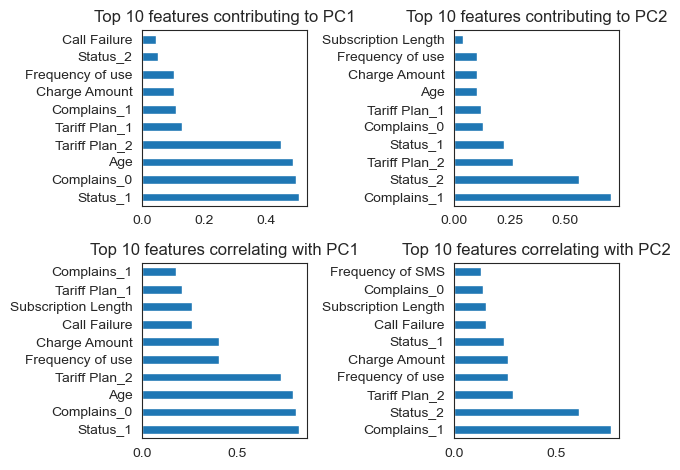

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import numpy as np

# Here I will modify the preprocessing step slightly so that 
# categorical names are still one-hot encoded, but now
# numerical features will be scaled:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ("num", StandardScaler(), numeric_cols)
    ]
)

# Apply preprocessing and scaling 
X_scaled = preprocess.fit_transform(X)

# Create a PCA object for reducing the dimensionality to 2 principal components
pca = PCA(n_components=2)

# Compute the 2 principal components
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)

# Get feature names after preprocessing
num_features = numeric_cols
cat_features = preprocess.named_transformers_["cat"].get_feature_names_out(categorical_cols)
all_features = np.concatenate([num_features, cat_features])

# Now create loadings DataFrame to show weights of all features to both PCs
loadings = pd.DataFrame(pca.components_.T, index=all_features, columns=['PC1_loading', 'PC2_loading'])

# Extract PC scores from PCA object
pc_scores = pd.DataFrame(X_pca, columns=['PC1_score','PC2_score'])

# Compute correlations of original features with PCs
correlations_pc1 = pd.Series(np.corrcoef(X_scaled.T, pc_scores['PC1_score'])[0:len(all_features), -1], index=all_features)
correlations_pc2 = pd.Series(np.corrcoef(X_scaled.T, pc_scores['PC2_score'])[0:len(all_features), -1], index=all_features)

# Combine loadings and correlations into one DataFrame
pca_results = pd.DataFrame({
    'PC1_loading': loadings['PC1_loading'],
    'PC2_loading': loadings['PC2_loading'],
    'PC1_corr': correlations_pc1,
    'PC2_corr': correlations_pc2
})

print(pca_results)

# Create two plots using subplot to rank and show the contributions of each feature 
# to the PCs
plt.subplot(2, 2, 1)
loadings['PC1_loading'].abs().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 features contributing to PC1")
plt.subplot(2, 2, 2)
loadings['PC2_loading'].abs().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 features contributing to PC2")
plt.tight_layout()

# Create two plots using subplot to rank and show the correlations of each feature 
# to the PCs
plt.subplot(2, 2, 3)
pca_results['PC1_corr'].abs().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 features correlating with PC1")
plt.subplot(2, 2, 4)
pca_results['PC2_corr'].abs().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 features correlating with PC2")
plt.tight_layout()


The explained variance ratio tells us that a large proportion of the variance can be explained by the first principal component (34.7%) while the second principal component only explains 15.6%. By inspecting the loadings (feature weights), we can see that the first principal component is largely driven by Status, Complains, Age and Tariff Plan, and the second principal component is largely driven by Complains and Status.

We can plot the customers in this PC space:

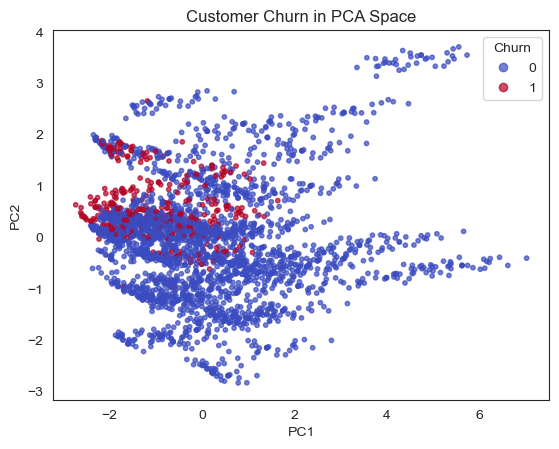

In [12]:
# Define sizes of the markers for each group
marker_sizes = np.where(y==1, 10, 10) 

# Create scatter plot with customers that churn in red, and those that do not in blue.
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df['Churn'], s=marker_sizes,cmap='coolwarm', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Customer Churn in PCA Space")
plt.legend(*scatter.legend_elements(), title="Churn")
plt.show()


We can investigate this further by plotting the customers who end their contracts and those who do not seperately. 

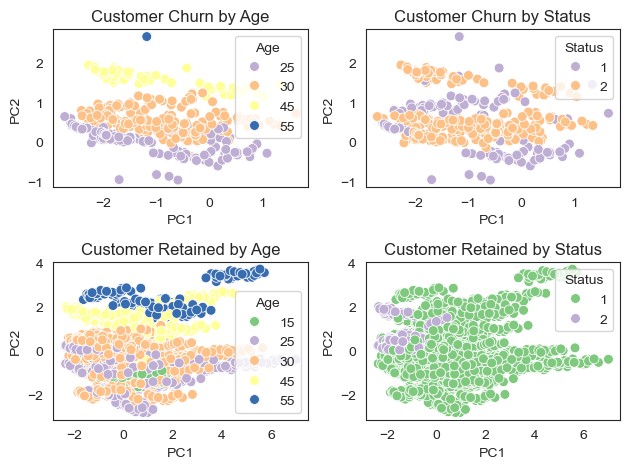

In [13]:
## Seaborn PCA plot
import seaborn as sns

# Create a boolean mask for customers that churn
mask = df["Churn"] == 1

# Define colour palette here for first plot (four colours)
palette = ['#beaed4', '#fdc086', '#ffff99', '#386cb0']

# Set the style of the plot
sns.set_style("white")

# Arrange the subplot
plt.subplot(2, 2, 1)

# Create the scatter plot, selecting only customers that churn and colour by Age
scatter = sns.scatterplot(
    x = X_pca[mask, 0],            
    y = X_pca[mask, 1],            
    hue = df.loc[mask, "Age"],     
    s = 50,   
    palette = palette,                 
    alpha = 1
)
scatter.set(xlabel='PC1', ylabel='PC2', title = "Customer Churn by Age")

# Define colour palette here for second plot (two colours)
palette = ['#beaed4', '#fdc086']

# Arrange the subplot
plt.subplot(2, 2, 2)

# Create the scatter plot, selecting only customers that churn and colour by Status
scatter = sns.scatterplot(
    x = X_pca[mask, 0],            
    y = X_pca[mask, 1],            
    hue = df.loc[mask, "Status"],     
    s = 50,   
    palette = palette,                 
    alpha = 1
)
scatter.set(xlabel='PC1', ylabel='PC2', title = "Customer Churn by Status")

# Create a boolean mask for customers that remain
mask2 = df["Churn"] == 0

# Define colour palette here for first plot (four colours)
palette = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0']

# Arrange the subplot
plt.subplot(2, 2, 3)

# Create the scatter plot, selecting only customers that remain and colour by Age
scatter = sns.scatterplot(
    x = X_pca[mask2, 0],            
    y = X_pca[mask2, 1],            
    hue = df.loc[mask2, "Age"],     
    s = 50,   
    palette = palette,                 
    alpha = 1
)
scatter.set(xlabel='PC1', ylabel='PC2', title = "Customer Retained by Age")

# Define colour palette here for first plot (four colours)
palette = ['#7fc97f', '#beaed4']

# Arrange the subplot
plt.subplot(2, 2, 4)

# Create the scatter plot, selecting only customers that remain and colour by Age
scatter = sns.scatterplot(
    x = X_pca[mask2, 0],            
    y = X_pca[mask2, 1],            
    hue = df.loc[mask2, "Status"],     
    s = 50,   
    palette = palette,                 
    alpha = 1
)
scatter.set(xlabel='PC1', ylabel='PC2', title = "Customer Retained by Status")

# Remove white space
plt.tight_layout()

Age appears to be correlated with PC2, however from the correlation calculations above, we know it is most correlated with PC1. What has happened here is that the PCA components have mixed signs, so the axes for these components may have been flipped i.e. rotated around 180 degrees. We can check this by looking at the signs of the pca components:

In [53]:
np.sign(pca.components_)

array([[-1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1., -1., -1.,  1., -1.,  1.,  1., -1.,  1., -1., -1., -1.,  1.]])

This will not affect the results of the PCA, but is something to be aware of when trying to interpret PCA scatter plots.